In [1]:
import tensorflow as tf
print(tf.__version__)


2.18.0


In [28]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os


(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
x_train = np.expand_dims(x_train, axis=-1)

num_classes = 10
image_shape = (28, 28, 1)
noise_dim = 100

y_train_ohe = tf.keras.utils.to_categorical(y_train, num_classes)


def build_generator():
    noise_input = layers.Input(shape=(noise_dim,))
    label_input = layers.Input(shape=(num_classes,))

    x = layers.Concatenate()([noise_input, label_input])
    x = layers.Dense(7 * 7 * 512, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((7, 7, 512))(x)

    x = layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    img = layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)

    return tf.keras.Model([noise_input, label_input], img)

def build_discriminator():
    img_input = layers.Input(shape=image_shape)
    label_input = layers.Input(shape=(num_classes,))
    label_expanded = layers.Dense(np.prod(image_shape))(label_input)
    label_expanded = layers.Reshape(image_shape)(label_expanded)

    x = layers.Concatenate()([img_input, label_expanded])
    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model([img_input, label_input], output)

generator = build_generator()
discriminator = build_discriminator()

cross_entropy = tf.keras.losses.BinaryCrossentropy()


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) * 0.9, real_output)  # Label smoothing
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


initial_lr = 1e-4
generator_optimizer = tf.keras.optimizers.Adam(initial_lr)
discriminator_optimizer = tf.keras.optimizers.Adam(initial_lr)

@tf.function
def train_step(images, labels):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, labels], training=True)

        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def generate_and_save_images(model, epoch, test_input, test_labels):
    predictions = model([test_input, test_labels], training=False)
    predictions = (predictions + 1) / 2.0

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.close()

EPOCHS = 9000  # Training time
BATCH_SIZE = 256
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])
fixed_labels = np.eye(num_classes)[np.random.choice(num_classes, num_examples_to_generate)]
fixed_labels = tf.convert_to_tensor(fixed_labels, dtype=tf.float32)


for epoch in range(1, EPOCHS + 1):
    idx = np.random.randint(0, x_train.shape[0], BATCH_SIZE)
    real_images = x_train[idx]
    real_labels = y_train_ohe[idx]

    gen_loss, disc_loss = train_step(real_images, real_labels)

    # تقليل Learning rate بعد 1000 epochs
    if epoch == 1000:
        generator_optimizer.learning_rate = 1e-5
        discriminator_optimizer.learning_rate = 1e-5

    if epoch % 100 == 0:
        generate_and_save_images(generator, epoch, seed, fixed_labels)
        print(f'Epoch {epoch}, Gen Loss: {gen_loss.numpy()}, Disc Loss: {disc_loss.numpy()}')


generator.save("CGAN_generator_model_v2.h5")
print("✅ Generator model saved as CGAN_generator_model_v2.h5")


Epoch 100, Gen Loss: 0.8819351196289062, Disc Loss: 1.2700002193450928
Epoch 200, Gen Loss: 0.7923362851142883, Disc Loss: 1.3507447242736816
Epoch 300, Gen Loss: 0.7834339737892151, Disc Loss: 1.3666331768035889
Epoch 400, Gen Loss: 0.7517690658569336, Disc Loss: 1.4688674211502075
Epoch 500, Gen Loss: 0.8042851686477661, Disc Loss: 1.340198040008545
Epoch 600, Gen Loss: 0.9833194613456726, Disc Loss: 1.15423583984375
Epoch 700, Gen Loss: 0.9458767175674438, Disc Loss: 1.3649787902832031
Epoch 800, Gen Loss: 0.7623312473297119, Disc Loss: 1.6742689609527588
Epoch 900, Gen Loss: 0.8232691287994385, Disc Loss: 1.27484130859375
Epoch 1000, Gen Loss: 0.7359393835067749, Disc Loss: 1.5011640787124634
Epoch 1100, Gen Loss: 0.7936621308326721, Disc Loss: 1.4088261127471924
Epoch 1200, Gen Loss: 0.8211030960083008, Disc Loss: 1.3724453449249268
Epoch 1300, Gen Loss: 0.8271937370300293, Disc Loss: 1.3667688369750977
Epoch 1400, Gen Loss: 0.8264487981796265, Disc Loss: 1.4061996936798096
Epoch 

Epoch 9000, Gen Loss: 0.8291915655136108, Disc Loss: 1.356248140335083
✅ Generator model saved as CGAN_generator_model_v2.h5


In [29]:
from google.colab import files
files.download("CGAN_generator_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


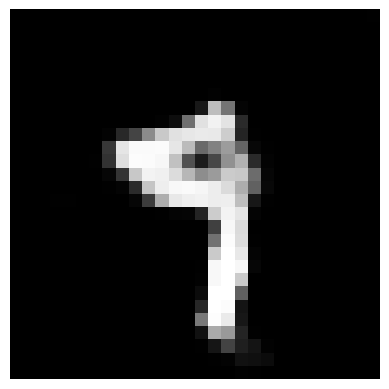

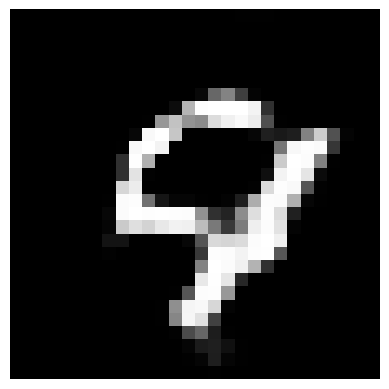

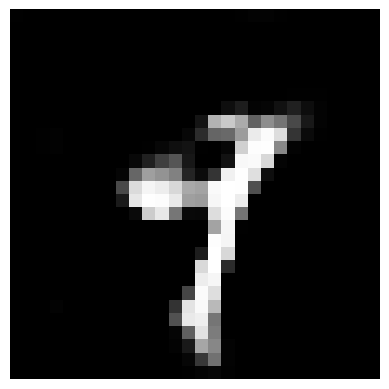

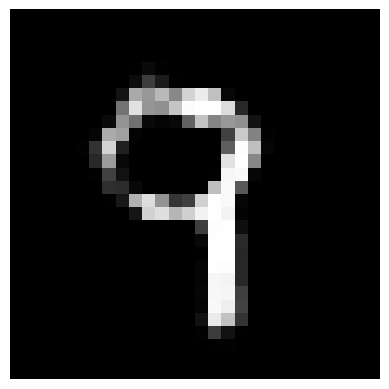

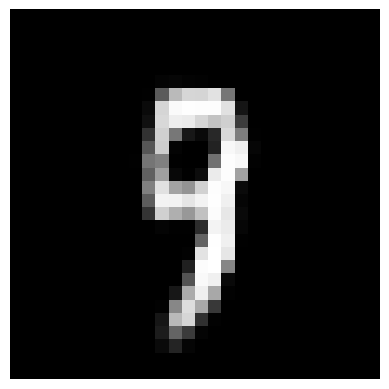

In [30]:
from tensorflow.keras.models import load_model

generator = load_model("CGAN_generator_model.h5")


digit = 9
noise = tf.random.normal([5, noise_dim])
label = tf.keras.utils.to_categorical([digit]*5, num_classes)

generated_images = generator.predict([noise, label])

for img in generated_images:
    plt.imshow(((img + 1) / 2.0).squeeze(), cmap="gray")
    plt.axis("off")
    plt.show()
